# Murat's multi-PCSF

### Murat's Algorithm
1. Obtain Z-score
2. Determine a terminal set for each patient based on Z-score. I used threshold values as 1<Z<3, 1.5<Z<3, 1.5<Z<4,
3. Compute a patient Distance Matrix, which was a total pairwise shortest paths between the terminal nodes of patient1 and patient2 divided by the union of the terminals of each patient,
4. Cluster the Distance Matrix using hierarchical clustering and obtain N clusters (I used N=10),
5. Average across the patients in the 10 clusters and do PCSF for all 10
6. Identify common Steiner nodes for each cluster and perform enrichment analysis

I did until this point, some stuff can be done to conclude the pipeline:
7. Determine the functional similarities and differences between the clusters,
8. Drill down to the structural similarity/difference (both patient-wise and cluster-wise, or within/across clusters),
9. Perform strong biological interpretation of similarities and differences

In [1]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from OmicsIntegrator import *

interactome_file = "/Users/alex/Documents/OmicsIntegrator2/data/inbiomap_exp.normalized.cleaned.connected.tsv"
graph = Graph(interactome_file, {})


In [2]:
brca = pd.read_csv('../../proteomics/data_preparation/proteomics_data/brca_inbiomap_exp.tsv', index_col=0)
brca.head()

,ZNF91,NDEL1,ELAVL1,SUMO1,SUMO3,CHMP5,UBC,HTT,E2F4,ACP5,...,SPANXN4,ZNF605,SERPINB10,ANKAR,RRH,DHH,CYSLTR1,ZNF268,COL23A1,MEDAG
AO-A12D.01TCGA,-1.102122,0.025578,0.071295,-0.225869,1.118990,-0.119194,0.0,0.166540,-0.519223,-0.747811,...,0.0,0.014149,-1.189748,0.000000,0.0,0.0,0.0,-4.001379,0.000000,0.0
C8-A131.01TCGA,-0.644553,1.901564,-0.547404,-0.369297,-1.073629,-0.786229,0.0,0.169071,0.237885,1.496776,...,0.0,-0.624314,6.163982,0.000000,0.0,0.0,0.0,3.848595,0.000000,0.0
AO-A12B.01TCGA,1.274661,0.573478,-0.263507,-1.291724,-2.197996,1.307918,0.0,0.254758,-0.371595,1.055714,...,0.0,-0.039018,-0.801173,0.000000,0.0,0.0,0.0,-1.147607,0.000000,0.0
E2-A10A.02TCGA,-9.048165,0.071716,0.055571,-6.868527,-7.366730,0.163976,0.0,-0.020544,-1.863433,1.054283,...,0.0,-12.593247,-5.277046,0.180121,0.0,0.0,0.0,0.466127,-5.390064,0.0
BH-A18Q.02TCGA,-3.728792,0.155196,0.543260,-0.617587,0.717220,-0.012073,0.0,-0.420210,1.677345,1.302662,...,0.0,-8.271821,-1.701491,-0.998961,0.0,0.0,0.0,-3.307274,-1.310081,0.0


## 1. Z-Scores

In [3]:
brca_zscore = (brca - brca.mean()) / brca.std(ddof=0)
brca_zscore.head()

,ZNF91,NDEL1,ELAVL1,SUMO1,SUMO3,CHMP5,UBC,HTT,E2F4,ACP5,...,SPANXN4,ZNF605,SERPINB10,ANKAR,RRH,DHH,CYSLTR1,ZNF268,COL23A1,MEDAG
AO-A12D.01TCGA,0.002986,-0.289911,0.062783,0.557650,0.958249,-0.171647,NaN,0.482968,-0.141760,-0.799239,...,NaN,0.714672,0.206023,-0.050453,NaN,NaN,NaN,-1.106782,0.210763,NaN
C8-A131.01TCGA,0.181735,2.125176,-0.717380,0.513374,0.271594,-1.012493,NaN,0.487304,0.421157,0.940223,...,NaN,0.552333,3.024234,-0.050453,NaN,NaN,NaN,1.331091,0.210763,NaN
AO-A12B.01TCGA,0.931475,0.415439,-0.359394,0.228626,-0.080521,1.627332,NaN,0.634128,-0.031997,0.598419,...,NaN,0.701153,0.354939,-0.050453,NaN,NaN,NaN,-0.220520,0.210763,NaN
E2-A10A.02TCGA,-3.101132,-0.230514,0.042954,-1.492905,-1.699195,0.185309,NaN,0.162404,-1.141191,0.597309,...,NaN,-2.490949,-1.360374,0.052665,NaN,NaN,NaN,0.280638,-4.178832,NaN
BH-A18Q.02TCGA,-1.023122,-0.123044,0.657917,0.436729,0.832428,-0.036613,NaN,-0.522413,1.491407,0.789793,...,NaN,-1.392161,0.009905,-0.622351,NaN,NaN,NaN,-0.891222,-0.856149,NaN


## 2. Determine a terminal set for each patient

Murat used threshold values as 1<Z<3, 1.5<Z<3, 1.5<Z<4. It's unclear why we would want to clip above, so I won't. I'll also take the abs first. 

In [4]:
brca_zscore = abs(brca_zscore)

In [5]:
len(brca_zscore.transpose())

16349

In [6]:
len(brca_zscore.where(brca_zscore > 1.5).loc['AO-A12D.01TCGA'].dropna())

1411

In [7]:
len(brca_zscore.where(brca_zscore > 2).loc['AO-A12D.01TCGA'].dropna())

581

In [8]:
brca_zscore = brca_zscore.where(brca_zscore > 2)
terminals = {patient: brca_zscore.loc[patient].dropna().index.tolist() for patient in brca_zscore.index.tolist()}

## 3. Compute a patient Distance Matrix

In [9]:
graph.interactome_graph

In [10]:
nx.number_connected_components(graph.interactome_graph)

1

### 3.1 Compute all-pairs shortest paths

In [11]:
shortest_paths = nx.all_pairs_shortest_path_length(graph.interactome_graph)

In [14]:
pickle.dump(shortest_paths, open('../data/shortest_paths.pickle', 'wb'))

sanity check:

In [13]:
sum(list(map(len, shortest_paths.values()))) == 16349**2

True

### 3.2 Define a distance metric:

In [11]:
from itertools import product

def distance(set1, set2):
    
    denominator = float(len([(a, b) for a, b in product(set1, set2) if a != b]))
    
    return sum([sum([shortest_paths[node1][node2] for node2 in set2]) for node1 in set1]) / denominator 


### 3.3 Build the distance matrix

In [12]:
shortest_paths = pickle.load(open('../data/shortest_paths.pickle', 'rb'))

In [13]:
matrix = pd.DataFrame({patient1: {patient2: distance(terminals1, terminals2) for patient2, terminals2 in terminals.items()} for patient1, terminals1 in terminals.items()})

In [15]:
matrix.to_pickle('../data/distance_matrix.pickle')

### 3.4 Inspect the results as a heatmap

In [3]:
matrix = pd.read_pickle('../data/distance_matrix.pickle')

In [16]:
brca_labels = pd.read_csv('../../proteomics/data_preparation/proteomics_data/raw/brca_labels.csv', index_col=0).loc['PAM50 mRNA']
brca_labels.index = brca_labels.index.str.split('.').str[0]


In [17]:
corrected_labels = matrix.index.str.replace('TCGA', '').str.split('.').str[0]
matrix.index = corrected_labels
matrix.columns = corrected_labels

In [18]:
colors = dict(zip(brca_labels.unique(), sns.husl_palette(len(brca_labels.unique()))))
colors = brca_labels.map(colors)

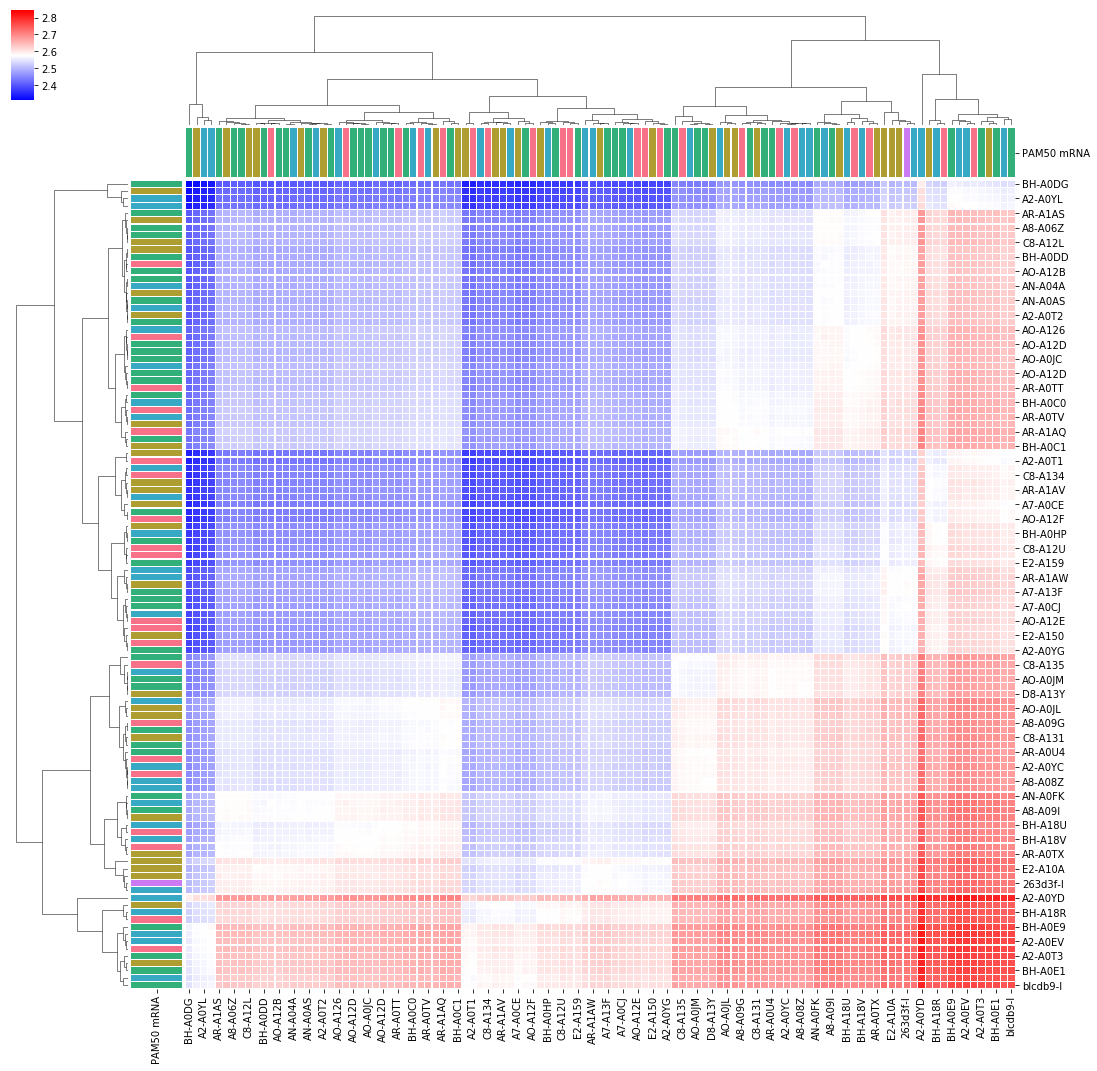

In [19]:
sns.clustermap(matrix, cmap='bwr', col_colors=colors, row_colors=colors, linewidths=.1, figsize=(18, 18))

### 3.5 Compare to patient correlation matrix

In [20]:
brca.index = corrected_labels

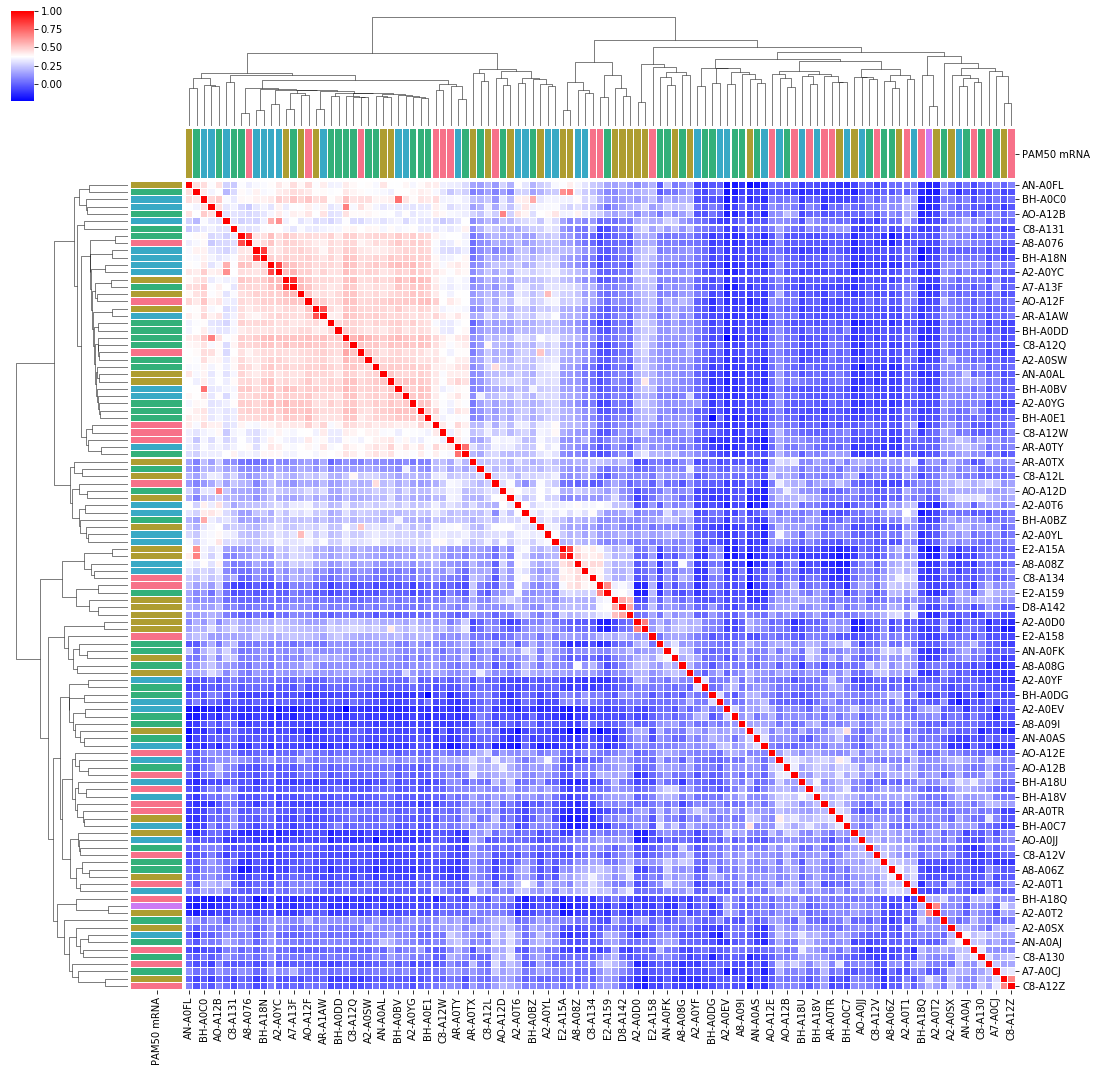

In [21]:
sns.clustermap(brca.transpose().corr(), cmap='bwr', col_colors=colors, row_colors=colors, linewidths=.1, figsize=(18, 18))

### 3.6 Normalize Patient Distance Matrix by Self-Distance

In [22]:
normalized_matrix = matrix - matrix.values.diagonal()

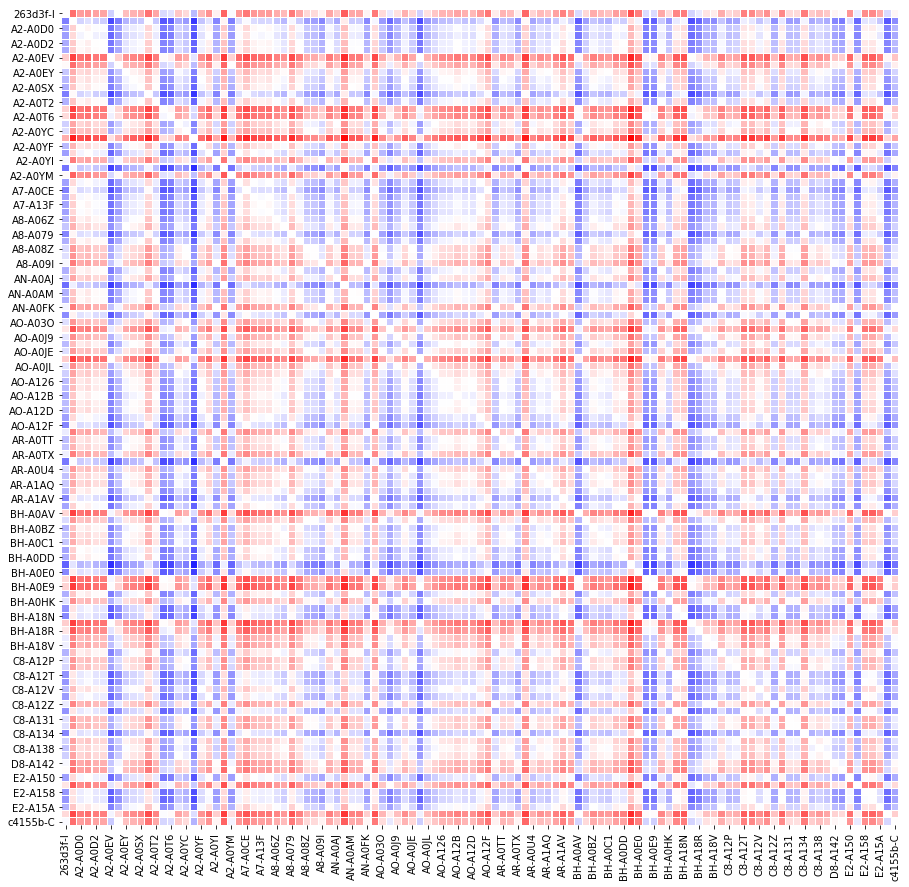

In [23]:
plt.subplots(figsize=(15,15))
sns.heatmap(normalized_matrix, cmap='bwr', center=0, linewidths=.1, cbar=False)

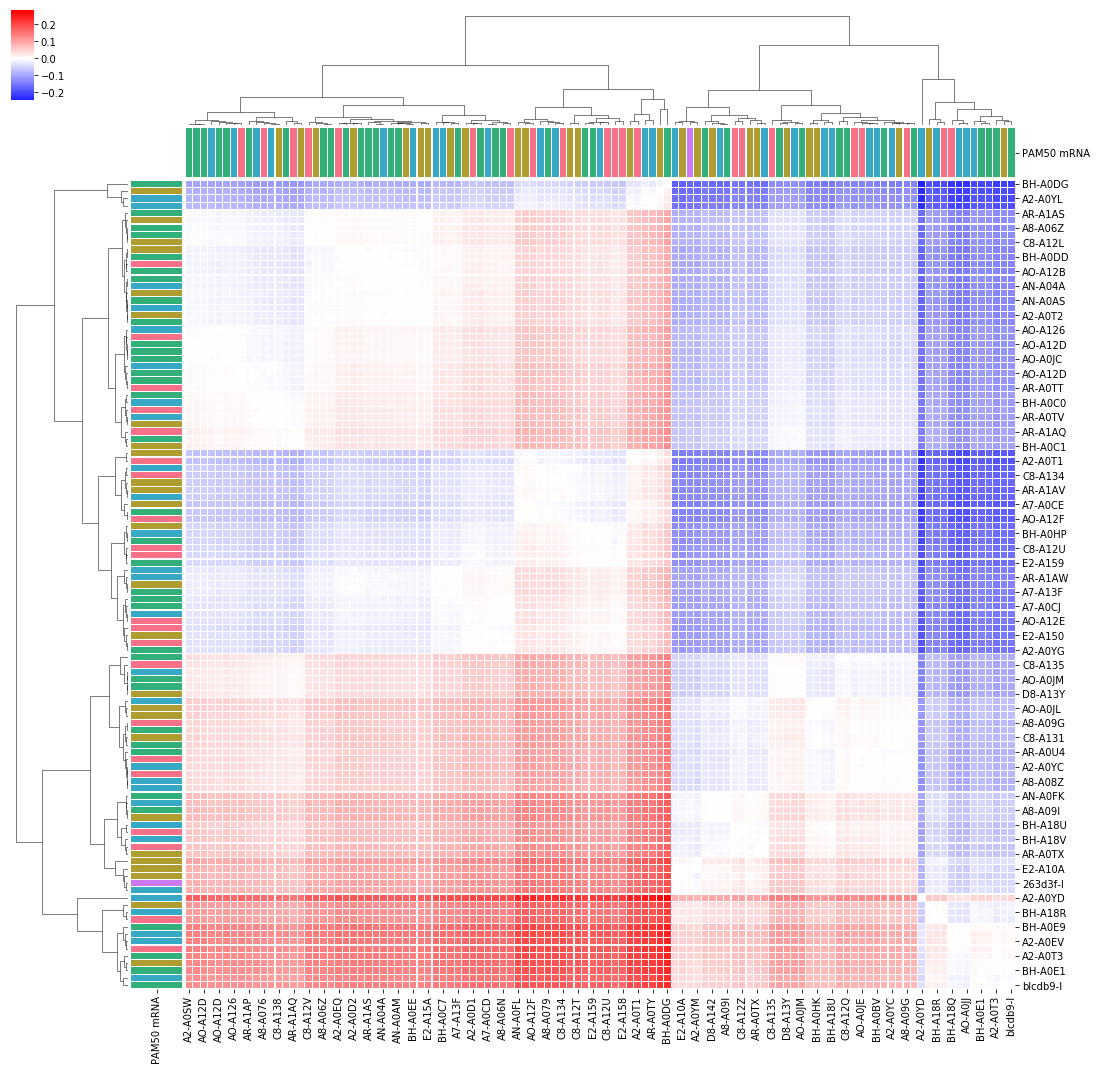

In [24]:
sns.clustermap(normalized_matrix, cmap='bwr', center=0, col_colors=colors, row_colors=colors, linewidths=.1, figsize=(18, 18))

In [25]:
final_matrix = normalized_matrix.join(brca_labels).dropna(subset=['PAM50 mRNA']).set_index('PAM50 mRNA', append=True).swaplevel().sort_index(level=0)
del final_matrix['263d3f-I'], final_matrix['blcdb9-I'], final_matrix['c4155b-C']
final_matrix.head()

A2-A0CM   A2-A0D0   A2-A0D1   A2-A0D2   A2-A0EQ  \
PAM50 mRNA                                                             
Basal-like A2-A0CM  0.000000 -0.046899 -0.034096 -0.051184 -0.054278   
           A2-A0D0  0.052043  0.000000  0.012075 -0.003982 -0.003456   
           A2-A0D2  0.058422  0.006683  0.019129  0.000000  0.000951   
           A2-A0SX  0.062691  0.012652  0.025306  0.007202  0.005013   
           A2-A0T2  0.062194  0.010589  0.023368  0.005794  0.006430   

                     A2-A0EV   A2-A0EX   A2-A0EY   A2-A0SW   A2-A0SX  \
PAM50 mRNA                                                             
Basal-like A2-A0CM -0.198735 -0.145406 -0.081545 -0.066266 -0.060082   
           A2-A0D0 -0.152515 -0.100221 -0.033740 -0.019713 -0.011180   
           A2-A0D2 -0.148345 -0.093584 -0.030331 -0.013518 -0.005965   
           A2-A0SX -0.140674 -0.088526 -0.022601 -0.007628  0.000000   
           A2-A0T2 -0.141911 -0.088314 -0.022272 -0.009629 -0.000102   

                      ...      C8-A135   C8-A138   D8-A13Y   D8-A142  \
PAM50 mRNA            ...                                              
Basal-like A2-A0CM    ...    -0.094013 -0.078210 -0.090416 -0.134660   
           A2-A0D0    ...    -0.049161 -0.030655 -0.045636 -0.089173   
           A2-A0D2    ...    -0.043089 -0.024691 -0.039240 -0.083902   
           A2-A0SX    ...    -0.036591 -0.020423 -0.033822 -0.077468   
           A2-A0T2    ...    -0.037806 -0.019866 -0.033716 -0.078513   

                     E2-A10A   E2-A150   E2-A154   E2-A158   E2-A159   E2-A15A  
PAM50 mRNA                                                                      
Basal-like A2-A0CM -0.144937 -0.036609 -0.166052 -0.028712 -0.025850 -0.061684  
           A2-A0D0 -0.099413  0.011047 -0.122124  0.017919  0.021705 -0.010431  
           A2-A0D2 -0.094306  0.017305 -0.116441  0.026041  0.027592 -0.004760  
           A2-A0SX -0.086751  0.023722 -0.109954  0.030212  0.033986  0.000514  
           A2-A0T2 -0.088254  0.022136 -0.110784  0.028738  0.031758 -0.000486  

[5 rows x 108 columns]

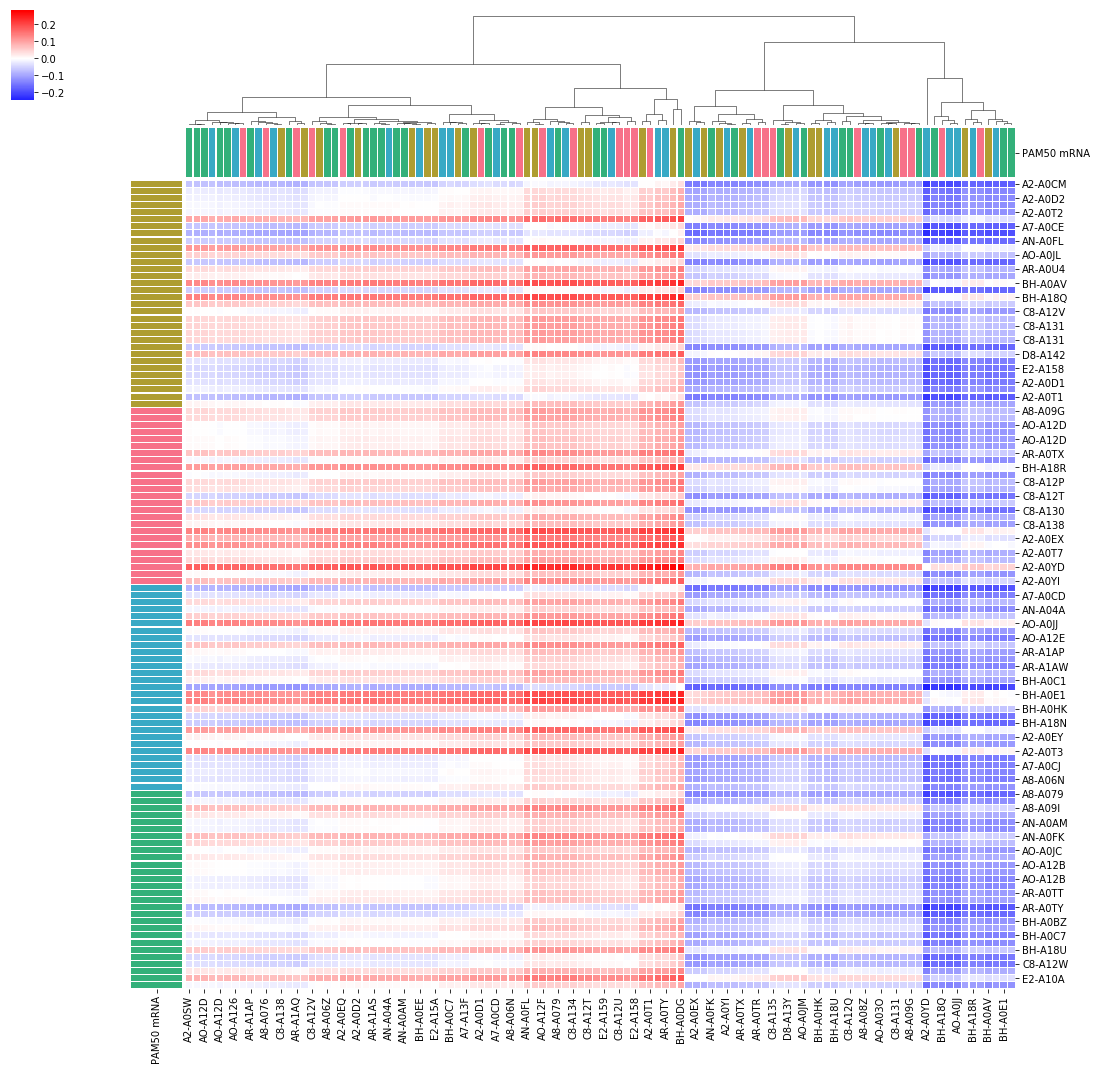

In [26]:
sns.clustermap(final_matrix.reset_index(level=0, drop=True), cmap='bwr', center=0, col_colors=colors, row_colors=colors, row_cluster=False,  linewidths=.1, figsize=(18, 18))